In [2]:
import pandas as pd

from plotnine import *

import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as rvectors
from rpy2.robjects import pandas2ri

import scipy as sp
import statsmodels as sm

%matplotlib inline
r = ro.r

Activate the pandas conversion for rpy2. See, https://pandas.pydata.org/pandas-docs/stable/r_interface.html

In [3]:
pandas2ri.activate()

Import the R packages that will be used in this analysis.

In [4]:
packageNames = ('afex', 'lsmeans', 'coin')
 
if all(rpackages.isinstalled(x) for x in packageNames):
    have_packages = True
else:
   have_packages = False
 
if not have_packages:
    utils = rpackages.importr('utils')
    utils.chooseCRANmirror(ind=1)
    packnames_to_install = [x for x in packageNames if not rpackages.isinstalled(x)]
 
    if len(packnames_to_install) > 0: 
        utils.install_packages(rvectors.StrVector(packnames_to_install))

In [5]:
lsm  = rpackages.importr('lsmeans')
afex = rpackages.importr('afex') 
coin = rpackages.importr('coin')

t_test = ro.r('t.test')
friedman_test = ro.r('friedman.test')
wilcox_test = ro.r('wilcox.test')
p_adjust = ro.r('p.adjust')

Set the theme to use in plotnine.

In [6]:
theme_set(theme_xkcd())

In [12]:
df = pd.read_csv("avatars.csv")
df.Subject = df.Subject.astype('category')
df.Sex = df.Sex.astype('category')
df.Avatar = df.Avatar.astype('category')
df.Positives = df.Positives.astype(int)

In [16]:
df.head(10)

,Subject,Sex,Avatar,Positives
0,1,Male,Male,78
1,2,Female,Male,104
2,3,Male,Female,89
3,4,Female,Female,71
4,5,Male,Male,61
5,6,Female,Male,65
6,7,Male,Female,109
7,8,Female,Female,47
8,9,Male,Male,65
9,10,Female,Male,107


In [17]:
df.groupby(['Sex']).describe()

Positives                                                        
           count       mean        std   min    25%   50%     75%    max
Sex                                                                     
Female      30.0  74.166667  24.140513  32.0  62.50  68.5   87.75  149.0
Male        30.0  96.033333  19.460806  61.0  83.25  93.5  109.75  135.0

In [18]:
df.groupby(['Avatar']).describe()

Positives                                                        
           count       mean        std   min    25%   50%     75%    max
Avatar                                                                  
Female      30.0  81.933333  26.122963  32.0  64.00  77.5  103.50  135.0
Male        30.0  88.266667  22.486675  54.0  73.25  84.5  104.75  149.0

Determine how many subjects took part in this experiment?

In [19]:
df.Subject.nunique()

60

In [20]:
df.groupby(['Sex', 'Avatar']).describe()

Positives                                                   \
                  count        mean        std   min   25%    50%    75%   
Sex    Avatar                                                              
Female Female      15.0   63.133333  17.484142  32.0  55.0   64.0   68.5   
       Male        15.0   85.200000  25.310077  54.0  68.0   81.0   98.0   
Male   Female      15.0  100.733333  18.721518  70.0  88.0  104.0  109.5   
       Male        15.0   91.333333  19.663842  61.0  80.5   85.0  108.5   

                      
                 max  
Sex    Avatar         
Female Female  102.0  
       Male    149.0  
Male   Female  135.0  
       Male    126.0

In [28]:
df.groupby(['Sex', 'Avatar']).mean().max()

Positives    100.733333
dtype: float64

In [68]:
groups = df.groupby(['Sex', 'Avatar']).mean().reset_index()

,Sex,Avatar,Positives
0,Female,Female,63.133333
1,Female,Male,85.200000
2,Male,Female,100.733333
3,Male,Male,91.333333


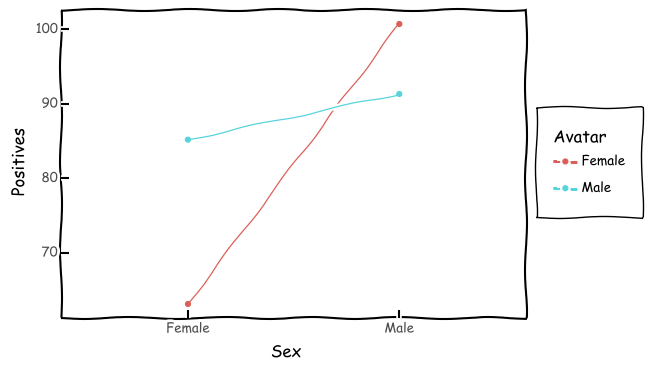

<ggplot: (297430729)>

In [75]:
groups = df.groupby(['Sex', 'Avatar']).mean().reset_index()

(
    ggplot(groups) +
    aes(x='Sex', y='Positives', group = 'Avatar', color='Avatar') +
    geom_line() +
    geom_point()
)

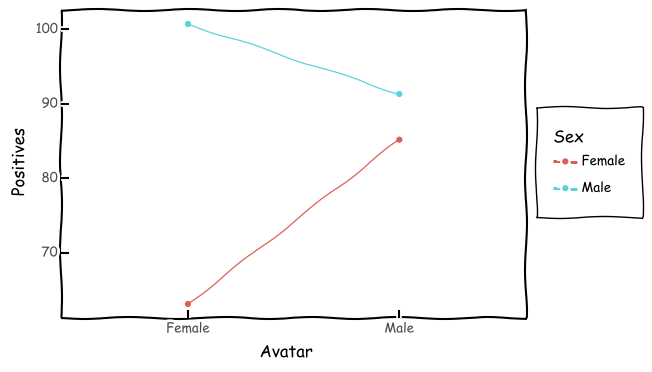

<ggplot: (297666829)>

In [76]:
(
    ggplot(groups) +
    aes(x='Avatar', y='Positives', group = 'Sex', color='Sex') +
    geom_line() +
    geom_point()
)

In [81]:
model = afex.aov_ez(id='Subject', dv='Positives', data=df, between=['Sex', 'Avatar'])
print(r.summary(model))

Anova Table (Type 3 tests)

Response: Positives
           num Df den Df    MSE       F      ges    Pr(>F)    
Sex             1     56 420.86 17.0418 0.233315 0.0001228 ***
Avatar          1     56 420.86  1.4296 0.024893 0.2368686    
Sex:Avatar      1     56 420.86  8.8225 0.136102 0.0043758 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



# References

1. https://sebastiansauer.github.io/vis_interaction_effects/
2. http://pltn.ca/plotnine-superior-python-ggplot/
3. https://quantdev.ssri.psu.edu/tutorials/five-ish-steps-create-pretty-interaction-plots-multi-level-model-r

# Answers

1. 30